In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler , LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:

def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();



def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm # type: ignore
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    



In [39]:
inpDir = 'D:\DNN\input' # location where input data is stored
outDir = '../output' # location to store outputs
#subDir = 'D:\DNN\images' # location of the images
modelDir = '../models'
altName = 'tf_cnn'
subDir = 'fashion_MNIST'
logDir = '../logs'
RANDOM_STATE = 24

tf.random.set_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 10 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate


# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'brg' # plt.cm.coolwarm

plt.rcParams.update(params)
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename , header=0)
test_df = pd.read_csv(test_filename , header=0)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
class_labels= {0 : 'T-shirt/top',
         1  : 'Trouser',
         2  : 'Pullover',
         3 : 'Dress',
         4 : 'Coat',
         5 : 'Sandal',
         6 : 'Shirt',
         7 : 'Sneaker',
         8 : 'Bag',
         9 : 'Ankle boot'}

In [6]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

<Axes: xlabel='label'>

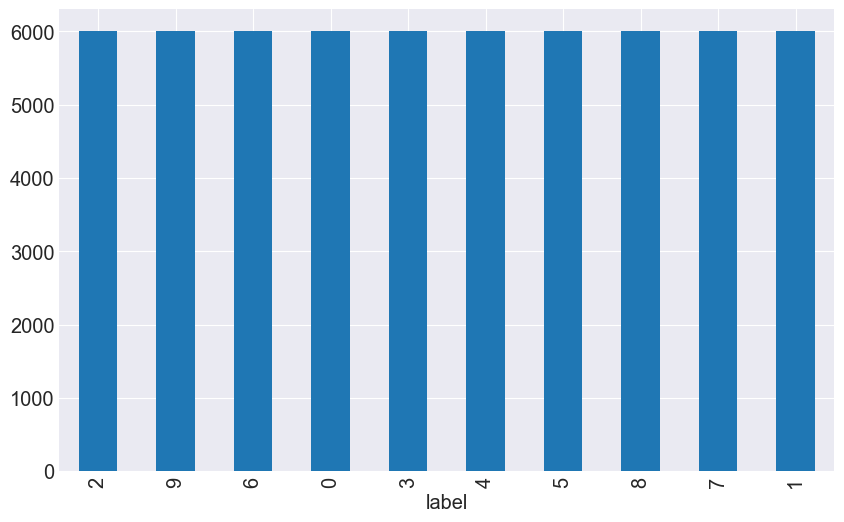

In [8]:
train_df['label'].value_counts().plot(kind='bar' , figsize=(10,6))

In [9]:
def split_feature_label(row):
    
    features = tf.reshape(row[1:], [28, 28, 1])
    
    labels = row[0]
    
    return features, labels

In [10]:
# Create training dataset
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(split_feature_label)

train_ds = train_ds.batch(BATCH_SIZE)


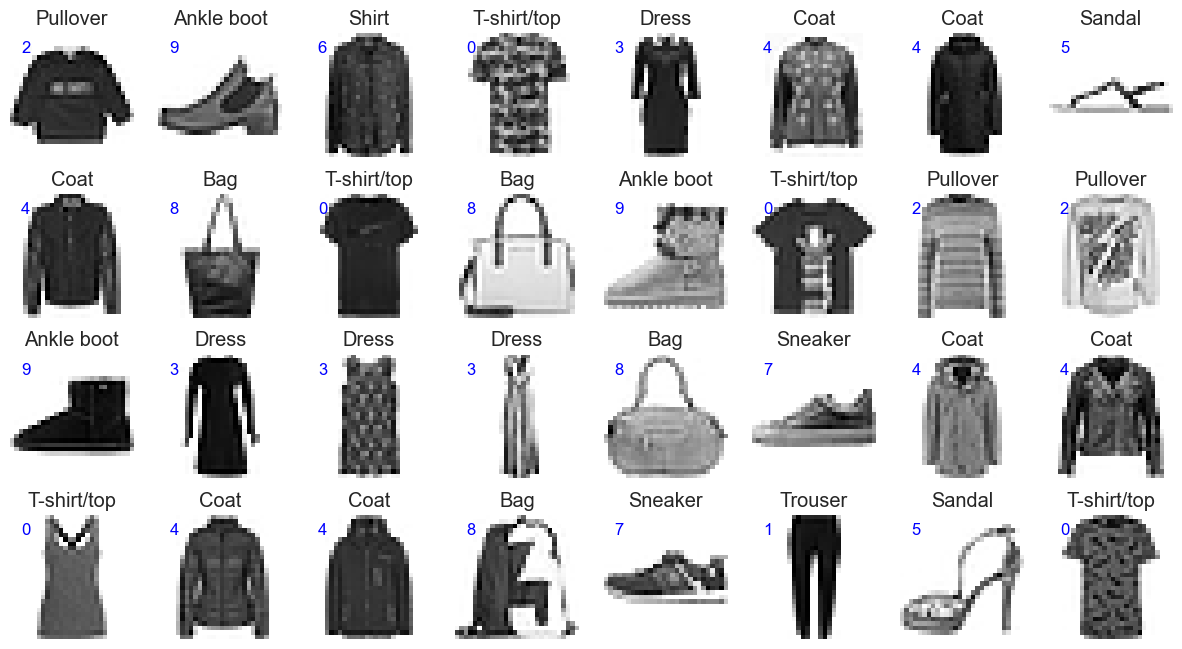

In [11]:
fig = plt.figure(figsize=(15,8))

for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE//4),i+1)
        
        plt.imshow(images[i].numpy().astype('uint16'), cmap=plt.cm.binary , interpolation='nearest')
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.show()

In [12]:
tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(split_feature_label)

test_ds = test_ds.batch(BATCH_SIZE)

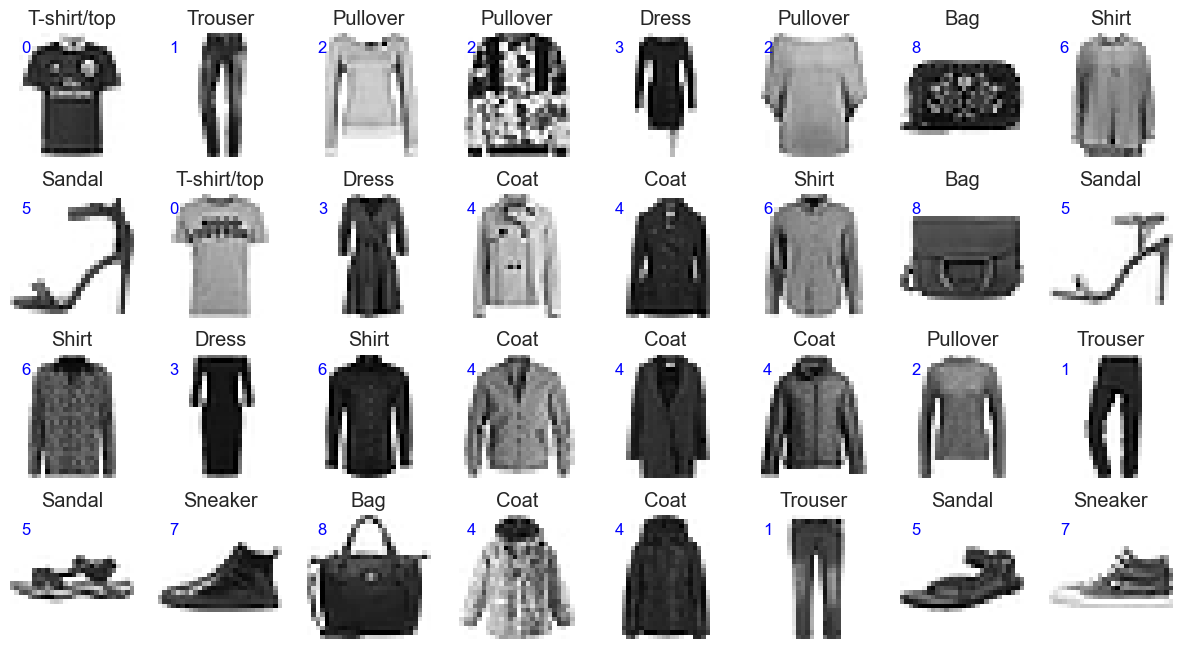

In [13]:
fig = plt.figure(figsize=(15,8))

for images, labels in test_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE//4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype('uint16'), cmap=plt.cm.binary , interpolation='nearest')
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.show()

In [14]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
norm_layer = tf.keras.layers.Rescaling(1./225.)

images , labels = next(iter(train_ds))

img = images[0].numpy()

print(img.max() , img.min())

norm_ds = train_ds.map(lambda x , y :(norm_layer(x) , y ))

images , labels = next(iter(norm_ds))

img = images[0].numpy()

print(img.max() , img.min())


255 0
1.1333333 0.0


In [16]:
input_shape =(1,6,6,1)
X = tf.random.normal(input_shape)

<Axes: >

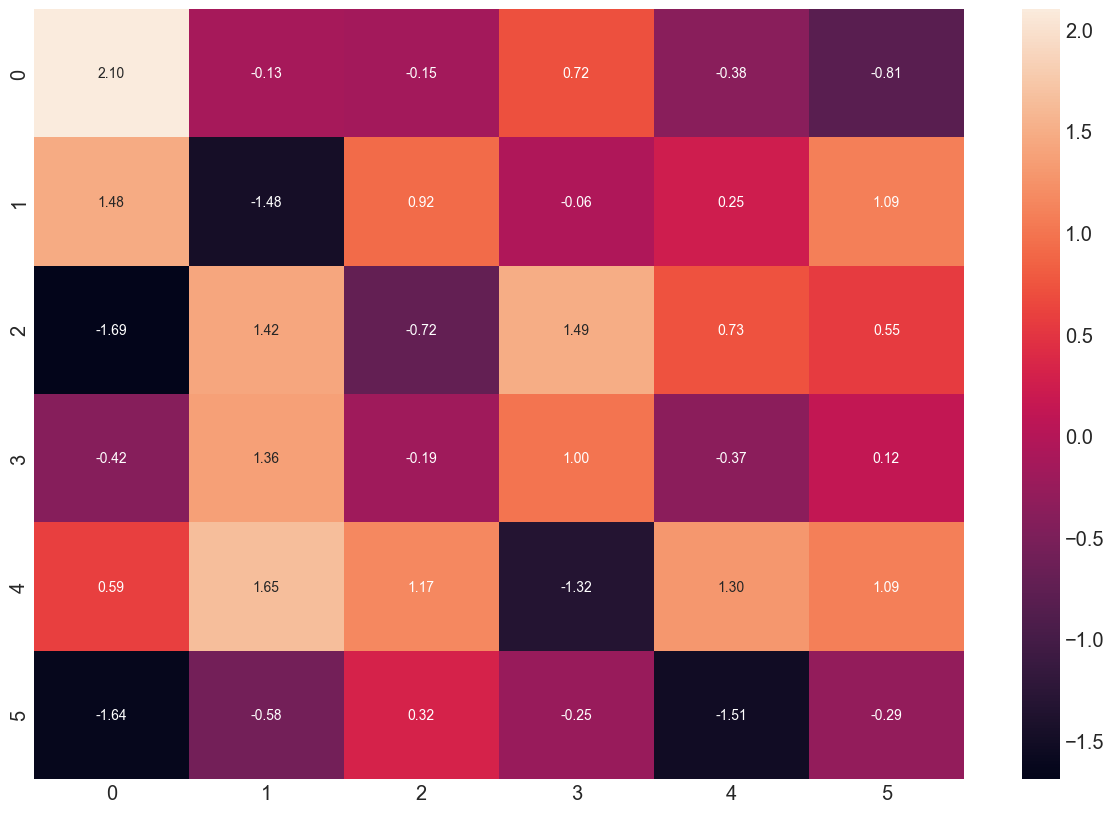

In [17]:
sns.heatmap(X.numpy()[0, :, :, 0], annot = True , fmt = '.2f')

In [18]:
y = tf.keras.layers.Conv2D(1 , 3 , 
                           kernel_initializer = tf.constant_initializer(1.) , use_bias = False,
                           activation = 'relu' , input_shape = input_shape[1:])(X)

y.shape

TensorShape([1, 4, 4, 1])

<Axes: >

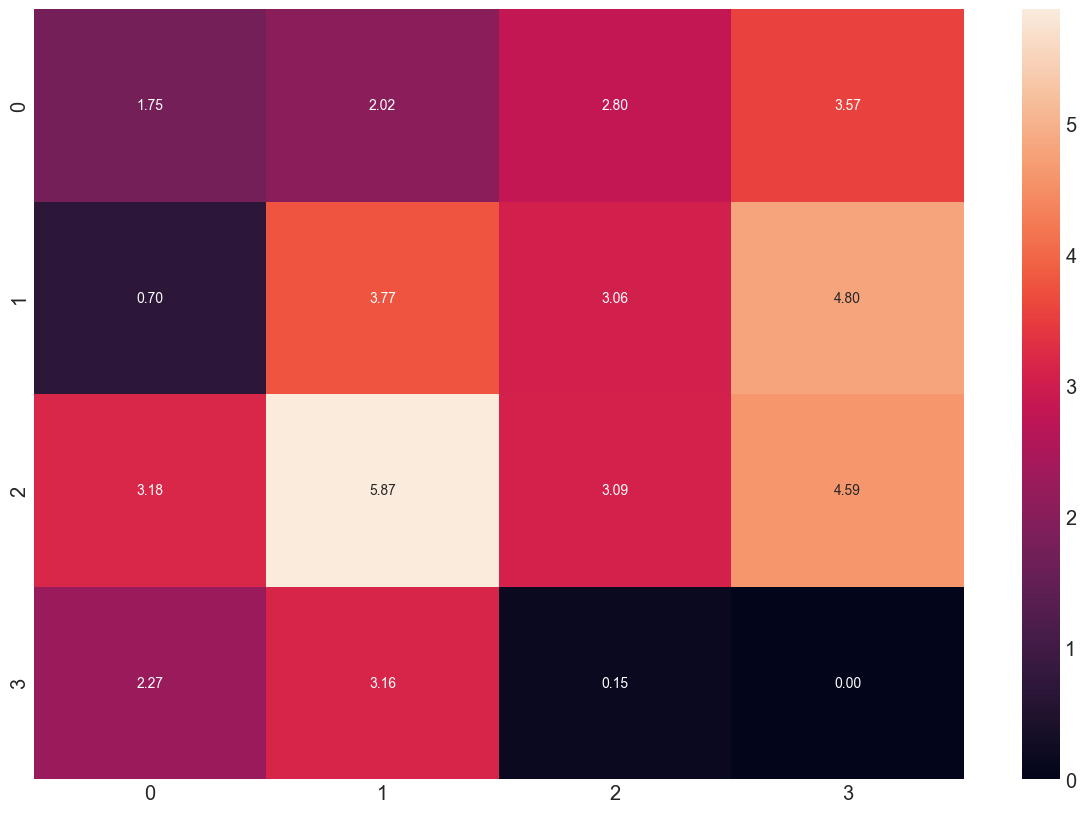

In [19]:
sns.heatmap(y.numpy()[0, :, :, 0], annot = True , fmt = '.2f' )

<Axes: >

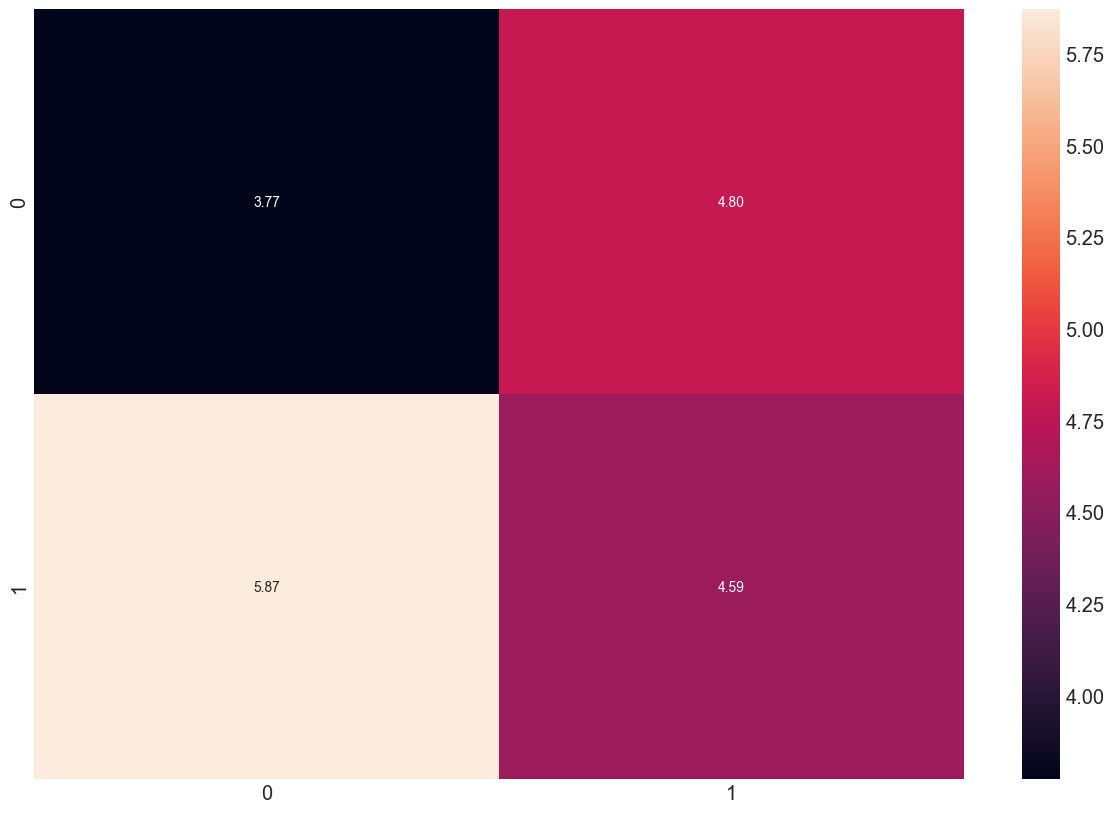

In [20]:
max_pool_layer = tf.keras.layers.MaxPool2D(pool_size=[2,2] , strides=(2,2) , padding = 'valid')

Z = max_pool_layer(y)

sns.heatmap(Z.numpy()[0, :, :, 0], annot = True , fmt = '.2f')


In [35]:
reg_lambda = 0.005

knl_red = tf.keras.regularizers.L2(reg_lambda)


model = tf.keras.Sequential()

model.add(tf.keras.layers.Rescaling(1./255.))

model.add(tf.keras.layers.Conv2D(32, 3 ,
    padding="same",
    activation = 'relu' ,
    kernel_regularizer = knl_red ,
    input_shape = (28,28,1)))

##########set1
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(64, 3 ,
    kernel_regularizer = knl_red,
    activation = 'relu' ))
##########set2
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#########set3
model.add(tf.keras.layers.Conv2D(128, 3 ,
    kernel_regularizer = knl_red,           
    activation = 'relu' ))

### Head

In [36]:
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64 , activation = 'relu' ,
    kernel_regularizer = knl_red
                                 ))

model.add(tf.keras.layers.Dense(10 ))

In [37]:
model.compile(optimizer='adam',
              
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              
              metrics=['accuracy'])


In [45]:
checkpoint_filepath = os.path.join(modelDir, subDir, 'weights_fashion')
PATIENCE = 20
LR_PATIENCE  = 10
LR_FACTOR = 0.1
model_ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = 'val_loss',
    mode = 'auto',
    save_best_only = True)


es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    verbose=2,
    restore_best_weights=True)


In [46]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[model_ckpt_callback, 
                               es_callback])

Epoch 1/10
   1/1875 [..............................] - ETA: 58s - loss: 0.6269 - accuracy: 0.8125

1875/1875 [==============================] - 33s 17ms/step - loss: 0.4756 - accuracy: 0.8748 - val_loss: 0.4762 - val_accuracy: 0.8711
Epoch 2/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.4711 - accuracy: 0.8761 - val_loss: 0.4739 - val_accuracy: 0.8713
Epoch 3/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.4671 - accuracy: 0.8764 - val_loss: 0.4700 - val_accuracy: 0.8695
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.4633 - accuracy: 0.8773 - val_loss: 0.4709 - val_accuracy: 0.8692
Epoch 5/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.4605 - accuracy: 0.8776 - val_loss: 0.4661 - val_accuracy: 0.8716
Epoch 6/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.4570 - accuracy: 0.8784 - val_loss: 0.4625 - val_accuracy: 0.8728
Epoch 7/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.4542 - accuracy: 0.8790 - val_loss: 0.4577 - val_accura

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 128)        

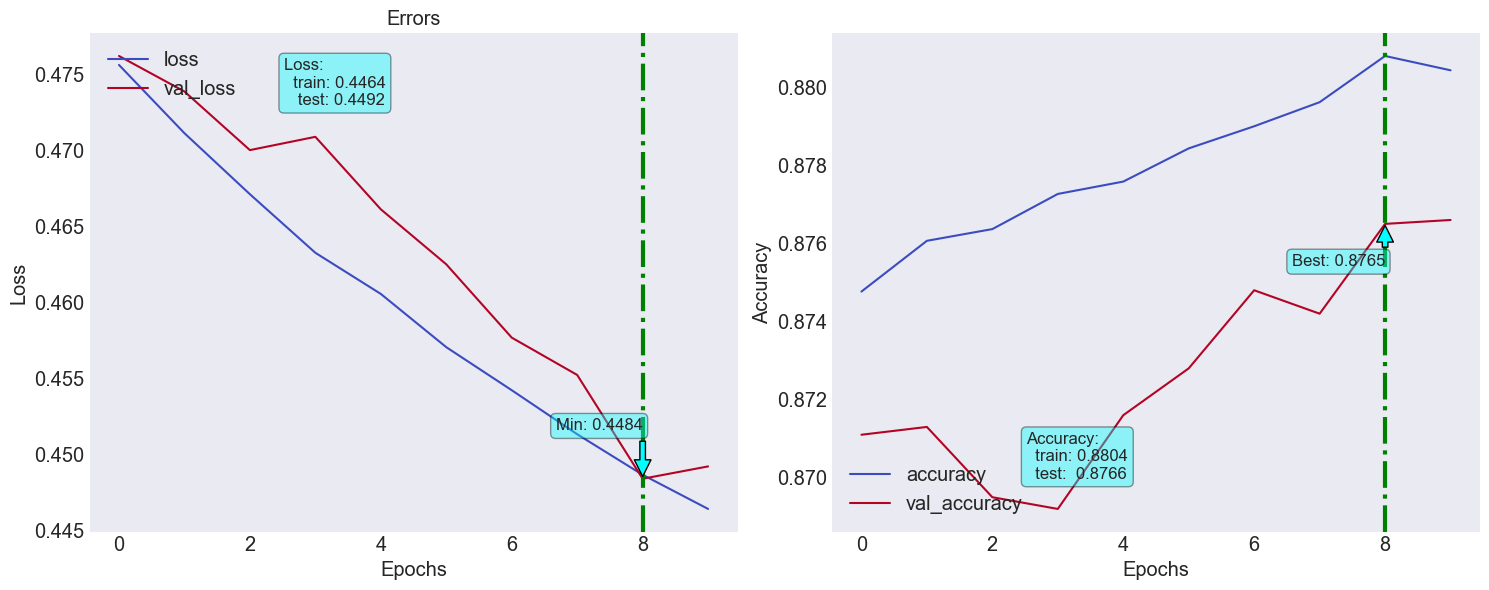

In [50]:
fn_plot_tf_hist(pd.DataFrame(history.history))

In [51]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

313/313 - 2s - loss: 0.4492 - accuracy: 0.8766 - 2s/epoch - 7ms/step


In [52]:
yhat = model.predict(test_ds)

  1/313 [..............................] - ETA: 10s

313/313 [==============================] - 2s 7ms/step


In [47]:
y_test = tf.concat([y for x, y in test_ds], axis=0).numpy()

In [48]:
y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data :', accuracy_score(y_test, y_pred))

Accuracy score on Test Data : 0.8708


In [53]:
confusion_matrix(y_test, y_pred)

array([[676,   1,  13,  79,   0,   3, 211,   1,  16,   0],
       [  0, 971,   0,  21,   1,   1,   6,   0,   0,   0],
       [  3,   0, 830,  17,  35,   0, 104,   0,  11,   0],
       [ 11,   6,   7, 922,  15,   0,  36,   0,   3,   0],
       [  0,   1,  87,  46, 720,   0, 144,   0,   2,   0],
       [  0,   1,   0,   0,   0, 915,   0,  65,   5,  14],
       [ 63,   2,  58,  38,  40,   0, 783,   0,  16,   0],
       [  0,   0,   0,   0,   0,   9,   0, 950,   0,  41],
       [  1,   1,   4,   1,   2,   0,   7,   4, 979,   1],
       [  0,   0,   0,   0,   0,   3,   0,  34,   1, 962]], dtype=int64)

In [54]:
test_df['y_pred'] = y_pred

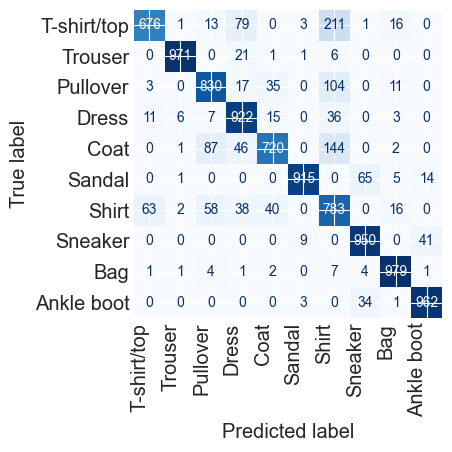

In [56]:
CMAP = plt.cm.Blues

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap=CMAP, colorbar=False);

ax.set_xticklabels(class_labels.values(),rotation=90, ha='right');